## Will this animal be adopted? 

Data source: 
https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and/data

Classification: This report classifies whether an animal is returned to a home or not. Specifically looking at the outcome_type column. The outcome types of Adoption, Return to Owner, and Rto-Adopt count as a successful adoption. The remaining outcomes are considered not to be adoption. 

In [2]:
import pandas as pd 
import numpy as np #numerical python 
from matplotlib import pyplot as plt #primary plotting library
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
# from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, LinearSVC 
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

In [3]:
data = pd.read_csv("aac_shelter_outcomes.csv")

## General Explorations

In [4]:
data.head(6)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown
5,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male


In [5]:
data.columns


Index(['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype',
       'outcome_type', 'sex_upon_outcome'],
      dtype='object')

In [6]:
len(data)

78256

#### There are 12 columns and 78,256 rows. 

#### 'age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome'

In [7]:
len(data[data.isnull().any(axis=1)])

60557

There are 60,557 rows with one null entry. 

## Review each Column 

### age_upon_outcome

#### Explorations

In [8]:
data.age_upon_outcome.unique()

array(['2 weeks', '1 year', '9 years', '5 months', '4 months', '3 years',
       '1 month', '3 months', '2 years', '2 months', '4 years', '8 years',
       '3 weeks', '8 months', '12 years', '7 years', '5 years', '6 years',
       '5 days', '10 months', '4 weeks', '10 years', '2 days', '6 months',
       '14 years', '11 months', '15 years', '7 months', '13 years',
       '11 years', '16 years', '9 months', '3 days', '6 days', '4 days',
       '5 weeks', '1 week', '1 day', '1 weeks', '0 years', '17 years',
       '20 years', '18 years', '19 years', '22 years', '25 years', nan],
      dtype=object)

In [9]:
len(data.age_upon_outcome.unique())

47

In [10]:
len(data[data.age_upon_outcome.isnull()])

8

There are 47 unique different ages. With 8 rows having a null age. 

#### Transformation

Converting the age_upon_outcome column to years. Since these are strings but can be made sense as a continuous 

In [11]:
age_upon_outcome_num = []
for item in data.age_upon_outcome:
    if type(item) == float: #if the row in nan
        age_upon_outcome_num.append(0)
    elif item.split()[1] == "years" or item.split()[1] == "year":
        age_upon_outcome_num.append(float(item.split()[0]))
    elif item.split()[1] == "months" or item.split()[1] == "month":
        age_upon_outcome_num.append(int(item.split()[0]) / 12)
    elif item.split()[1] == "weeks" or item.split()[1] == "week":
        age_upon_outcome_num.append(int(item.split()[0]) / 52)
    elif item.split()[1] == "days" or item.split()[1] == "day":
        age_upon_outcome_num.append(int(item.split()[0]) / 365)
    else: 
        print("WARNING: in final else: ", item)
        age_upon_outcome_num.append(None)
data['age_upon_outcome_num'] = age_upon_outcome_num
data = data.drop('age_upon_outcome', axis=1)

In [12]:
data.age_upon_outcome_num.describe()

count    78256.000000
mean         2.132660
std          2.895409
min          0.000000
25%          0.250000
50%          1.000000
75%          3.000000
max         25.000000
Name: age_upon_outcome_num, dtype: float64

#### The max age is 25. The mean age is 2.13. 

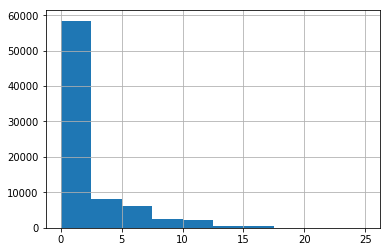

In [13]:
data.age_upon_outcome_num.hist()

The data is very left skewed. The animals overall tend to be younger. 

### animal_id

#### Exploration

In [14]:
len(data.animal_id.unique())

70855

Choosing to drop this column as it is different for almost every animal. It serves as a unique identifier. 

In [15]:
data = data.drop('animal_id', axis=1)

### animal_type

#### Exploration

In [16]:
data.animal_type.unique()

array(['Cat', 'Dog', 'Other', 'Bird', 'Livestock'], dtype=object)

There are 4 different identified types of animals and some "other" 

There are no NaN's in this column. However, there are some that are "Other." 

In [17]:
data.groupby('animal_type').size()

animal_type
Bird           334
Cat          29422
Dog          44242
Livestock        9
Other         4249
dtype: int64

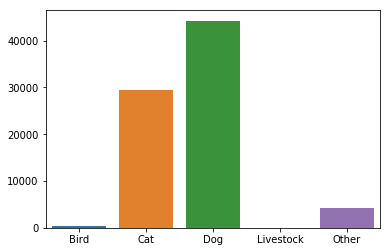

In [18]:
sns.barplot(x=['Bird', 'Cat', 'Dog','Livestock', 'Other'], y=data.groupby('animal_type').size())

Cats and dogs are a large majority of the animals. 

### breed

#### Exploration

In [19]:
data.breed.unique()

array(['Domestic Shorthair Mix', 'Beagle Mix', 'Pit Bull', ...,
       'Standard Schnauzer/German Shepherd', 'Pheasant Mix',
       'Cardigan Welsh Corgi/Miniature Schnauzer'], dtype=object)

In [20]:
len(data.breed.unique())

2128

In [21]:
len(data[data.breed.isnull()])

0

No NaN's in this column. However, there are many many different breeds, 2,128. This should be kept in consideration.

#### color

In [22]:
data.color.unique()

array(['Orange Tabby', 'White/Brown', 'Blue/White', 'White', 'Brown',
       'Brown/White', 'Tan', 'Blue Tabby/White', 'White/Black',
       'Black/White', 'Black', 'Brown Brindle/White', 'Brown Tabby',
       'Brown Tabby/White', 'Black Tabby', 'Tan/White', 'Brown Brindle',
       'Brown Brindle/Black', 'Yellow', 'Blue/Tan', 'Seal Point',
       'Torbie', 'Buff', 'Red/White', 'Black/Brown', 'Blue',
       'Cream Tabby/White', 'Calico', 'Brown Merle/White', 'Chocolate',
       'White/Brown Brindle', 'Fawn', 'Blue Merle/White', 'Brown/Black',
       'Sable', 'Cream', 'White/Tan', 'Black/Gray', 'Black/Tan',
       'Blue Tabby', 'Gray', 'White/Tricolor', 'Fawn/White', 'Red',
       'Red/Brown', 'Gray/Brown', 'Tricolor', 'Orange Tabby/White',
       'White/Blue', 'Red/Cream', 'Tricolor/Brown', 'Silver Tabby',
       'Flame Point', 'Red Tick/Brown Merle', 'White/Orange Tabby',
       'Chocolate/White', 'Black/Blue Merle', 'Tortie', 'Red Merle/White',
       'White/Buff', 'Cream Tabby', 'Apr

In [23]:
len(data.color.unique())

525

In [24]:
len(data[data.color.isnull()])

0

Good news, no NaN's in this column. There are once again, many colors. Maybe some colors could be condensed. 

### date_of_birth

#### Exploration

In [25]:
len(data[data.date_of_birth.isnull()])

0

In [26]:
data['date_of_birth_dt'] = pd.to_datetime(data['date_of_birth'])
data = data.drop('date_of_birth', axis=1)

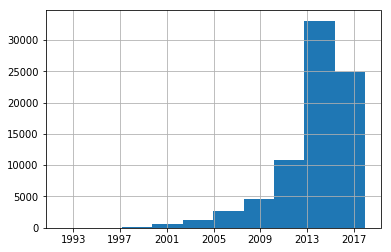

In [27]:
data.date_of_birth_dt.hist()

As was reflected in the age_upon_outcome. Most of the animals have more recent birthdates and are younger. 

No transformations are needed here. 

### datetime

#### Exploration 

In [28]:
data['datetime_dt'] = pd.to_datetime(data['datetime'])

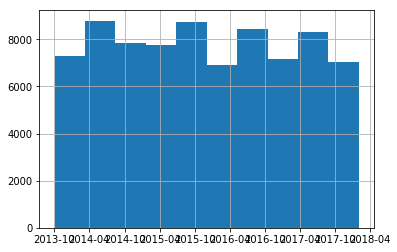

In [29]:
data.datetime_dt.hist()

#### monthyear

In [30]:
data['monthyear_dt'] = pd.to_datetime(data.monthyear)

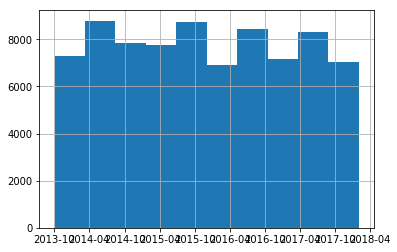

In [31]:
data.monthyear_dt.hist()

In [32]:
len(data[data.monthyear_dt != data.datetime_dt])

0

datatime and monthyear are the same data. Dropping the column monthyear. Also, based on data description, datetime seems like date that the outcome was determined. 

In [33]:
#cleaning up and renaming some columns 
data = data.drop('monthyear_dt', axis=1)
data = data.drop('monthyear', axis=1)
data = data.drop('datetime', axis=1)
data['outcome_dt'] = data['datetime_dt']
data = data.drop('datetime_dt', axis=1)
data.head()

,animal_type,breed,color,name,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt
0,Cat,Domestic Shorthair Mix,Orange Tabby,NaN,Partner,Transfer,Intact Male,0.038462,2014-07-07,2014-07-22 16:04:00
1,Dog,Beagle Mix,White/Brown,Lucy,Partner,Transfer,Spayed Female,1.000000,2012-11-06,2013-11-07 11:47:00
2,Dog,Pit Bull,Blue/White,*Johnny,NaN,Adoption,Neutered Male,1.000000,2013-03-31,2014-06-03 14:20:00
3,Dog,Miniature Schnauzer Mix,White,Monday,Partner,Transfer,Neutered Male,9.000000,2005-06-02,2014-06-15 15:50:00
4,Other,Bat Mix,Brown,NaN,Rabies Risk,Euthanasia,Unknown,0.416667,2014-01-07,2014-07-07 14:04:00


### name

#### Exploration

In [34]:
len(data[data.name.isnull()])

23886

In [35]:
len(data.name.unique())

14575

#### There are 14,575 unique names and 23,886 animals with no name. 

#### Transformation 

Create a new column of whether the animal has a name

In [36]:
data['has_name'] = [False if type(x) == float else True for x in data.name]
data = data.drop('name', axis=1)

### outcome_subtype

#### Exploration

In [37]:
len(data.outcome_subtype.unique())

20

This column further describes outcome_type, which is the y value. It should not be included in model creation.

In [38]:
data = data.drop('outcome_subtype', axis=1)

### outcome_type

In [39]:
data.outcome_type.unique()

array(['Transfer', 'Adoption', 'Euthanasia', 'Return to Owner', 'Died',
       'Disposal', 'Relocate', 'Missing', nan, 'Rto-Adopt'], dtype=object)

There are 10 different outcome types.

In [40]:
#data[data.outcome_type == 'Disposal']
len(data[data.outcome_type.isnull()])

12

#### Transformation
Creating an outcome_type simplified column. 
* adopted: {'Adoption', 'Return to Owner', 'Rto-Adopt'} 
* not: everything else


In [41]:
outcome = ['adopted' if outcome == 'Adoption' or outcome == 'Return to Owner' or outcome == 'Rto-Adopt' 
           else 'not' for outcome in data.outcome_type]
data['outcome'] = outcome
data = data.drop('outcome_type', axis=1)

In [42]:
data.head()

,animal_type,breed,color,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome
0,Cat,Domestic Shorthair Mix,Orange Tabby,Intact Male,0.038462,2014-07-07,2014-07-22 16:04:00,False,not
1,Dog,Beagle Mix,White/Brown,Spayed Female,1.000000,2012-11-06,2013-11-07 11:47:00,True,not
2,Dog,Pit Bull,Blue/White,Neutered Male,1.000000,2013-03-31,2014-06-03 14:20:00,True,adopted
3,Dog,Miniature Schnauzer Mix,White,Neutered Male,9.000000,2005-06-02,2014-06-15 15:50:00,True,not
4,Other,Bat Mix,Brown,Unknown,0.416667,2014-01-07,2014-07-07 14:04:00,False,not


In [43]:
data.groupby('outcome').size()

outcome
adopted    47616
not        30640
dtype: int64

#### 47,616 adopted and 30,640 not adopted

### sex_upon_outcome

#### Explorations

In [44]:
data.sex_upon_outcome.unique()

array(['Intact Male', 'Spayed Female', 'Neutered Male', 'Unknown',
       'Intact Female', nan], dtype=object)

In [45]:
data[data.sex_upon_outcome.isnull()] 

,animal_type,breed,color,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome
16300,Dog,Dachshund,Brown Merle,NaN,7.0,2006-11-17,2013-11-27 16:11:00,True,adopted
68246,Dog,Labrador Retriever Mix,Black/White,NaN,0.0,2013-11-02,2016-11-19 16:35:00,True,not


In [46]:
data['sex_upon_outcome'] = ['Unknown' if type(item) == float else item for item in data.sex_upon_outcome]

In [47]:
data.sex_upon_outcome.unique()

array(['Intact Male', 'Spayed Female', 'Neutered Male', 'Unknown',
       'Intact Female'], dtype=object)

In [48]:
data.groupby('sex_upon_outcome').size()

sex_upon_outcome
Intact Female     9143
Intact Male       9549
Neutered Male    27784
Spayed Female    25203
Unknown           6577
dtype: int64

5 types of sex_upon_outcome With some unknown

In [49]:
data[data.isnull().any(axis=1)]

,animal_type,breed,color,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome


In [50]:
data.head()

,animal_type,breed,color,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome
0,Cat,Domestic Shorthair Mix,Orange Tabby,Intact Male,0.038462,2014-07-07,2014-07-22 16:04:00,False,not
1,Dog,Beagle Mix,White/Brown,Spayed Female,1.000000,2012-11-06,2013-11-07 11:47:00,True,not
2,Dog,Pit Bull,Blue/White,Neutered Male,1.000000,2013-03-31,2014-06-03 14:20:00,True,adopted
3,Dog,Miniature Schnauzer Mix,White,Neutered Male,9.000000,2005-06-02,2014-06-15 15:50:00,True,not
4,Other,Bat Mix,Brown,Unknown,0.416667,2014-01-07,2014-07-07 14:04:00,False,not


#### Done cleaning the data.

In [51]:
data.columns

Index(['animal_type', 'breed', 'color', 'sex_upon_outcome',
       'age_upon_outcome_num', 'date_of_birth_dt', 'outcome_dt', 'has_name',
       'outcome'],
      dtype='object')

#### Label Encode the Data 

In [52]:
labelencoder = LabelEncoder()
data_label_encoded = data.copy()
data_label_encoded['animal_type'] = labelencoder.fit_transform(data_label_encoded['animal_type'])
data_label_encoded['breed'] = labelencoder.fit_transform(data_label_encoded['breed'])
data_label_encoded['color'] = labelencoder.fit_transform(data_label_encoded['color'])
data_label_encoded['sex_upon_outcome'] = labelencoder.fit_transform(data_label_encoded['sex_upon_outcome'])
data_label_encoded['date_of_birth_dt'] = labelencoder.fit_transform(data_label_encoded['date_of_birth_dt'])
data_label_encoded['outcome_dt'] = labelencoder.fit_transform(data_label_encoded['outcome_dt'])
data_label_encoded['outcome'] = labelencoder.fit_transform(data_label_encoded['outcome'])

In [53]:
data_label_encoded.head()

,animal_type,breed,color,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome
0,1,937,321,1,0.038462,4624,12401,False,1
1,2,255,474,3,1.000000,4016,1642,True,1
2,2,1613,119,2,1.000000,4161,9927,True,0
3,2,1468,463,2,9.000000,1401,10447,True,1
4,4,253,122,4,0.416667,4443,11509,False,1


In [151]:
#sns.pairplot(data_label_encoded)

In [ ]:
#sns.heatmap(data_label_encoded.corr())

The most correlated columns are age_upon_outcome_num and date_of_birth_dt, which are clearly directly relatied. Another stronger correlation is sex_upon_outcome and animal_type. Also, has_name and age_upon_outcome_num are somewhat correlated. 

In [55]:
data_label_encoded.head()

,animal_type,breed,color,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome
0,1,937,321,1,0.038462,4624,12401,False,1
1,2,255,474,3,1.000000,4016,1642,True,1
2,2,1613,119,2,1.000000,4161,9927,True,0
3,2,1468,463,2,9.000000,1401,10447,True,1
4,4,253,122,4,0.416667,4443,11509,False,1


In [56]:
x = data_label_encoded.iloc[:,:8] #all rows, all the features and no outcome
y = data_label_encoded.iloc[:,8] #all rows, outcome only
# scaler = StandardScaler()
# x=scaler.fit_transform(x)
# pca = PCA(n_components=6)
# x = pca.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=4)

In [57]:
#0 is adopted, 1 is not => 47,616 adopted
data_label_encoded.groupby('outcome').size()

outcome
0    47616
1    30640
dtype: int64

## Kmeans 

In [58]:
#N=X_train[:,0:2]
kmeans = KMeans(n_clusters=2, random_state=5)
kmeans.fit(X_train)
x_clustered = kmeans.predict(X_test)

In [59]:
x_clustered

array([1, 0, 0, ..., 1, 0, 0], dtype=int32)

In [60]:
accuracy_score(y_test, x_clustered)

0.5417199079989777

In [61]:
# LABEL_MAP = {0: 1, 1: 0}

# x_clustered = [LABEL_MAP[l] for l in x_clustered]

In [62]:
accuracy_score(y_test, x_clustered)

0.5417199079989777

In [63]:
confusion_matrix(y_test, x_clustered, labels=[0,1])

array([[5087, 4447],
       [2726, 3392]])

In [64]:
roc_auc_score(y_test, x_clustered)

0.5439968192843726

In [65]:
print(classification_report(y_test, x_clustered, target_names=['adopted', 'not adopted']))

             precision    recall  f1-score   support

    adopted       0.65      0.53      0.59      9534
not adopted       0.43      0.55      0.49      6118

avg / total       0.57      0.54      0.55     15652



54% accuracy score. Only 50% on ROC. 

## Linear Regression

In [66]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print(lr.intercept_)
print(lr.coef_)

0.5519560068030125
[ 4.20208869e-02 -2.00260829e-05 -1.00170243e-04 -8.14112270e-02
  3.64861328e-02  9.20050380e-05 -4.33843681e-06 -5.06290472e-01]


[0.33052595 0.23649899 0.13310535 ... 0.20696836 0.13155748 0.68175606]


(array([  15., 2009., 5412., 2717.,  713.,  651., 1437., 1387., 1104.,
         207.]),
 array([-0.0698632 ,  0.04314131,  0.15614583,  0.26915034,  0.38215486,
         0.49515938,  0.60816389,  0.72116841,  0.83417292,  0.94717744,
         1.06018196]),
 <a list of 10 Patch objects>)

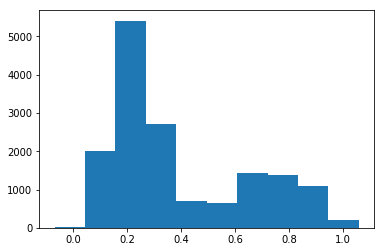

In [67]:
lr_pred = lr.predict(X_test)
print(lr_pred)
plt.hist(lr_pred)

In [68]:
lr_pred_outcome = [0 if x < .5 else 1 for x in lr_pred]

In [69]:
accuracy_score(y_test, lr_pred_outcome)

0.7574750830564784

In [70]:
confusion_matrix(y_test, lr_pred_outcome, labels=[0,1])

array([[8311, 1223],
       [2573, 3545]])

In [71]:
print(classification_report(y_test, lr_pred_outcome, target_names=['adopted', 'not adopted']))

             precision    recall  f1-score   support

    adopted       0.76      0.87      0.81      9534
not adopted       0.74      0.58      0.65      6118

avg / total       0.76      0.76      0.75     15652



In [72]:
roc_auc_score(y_test, lr_pred_outcome)

0.7255799909657308

## Logistic Regression

(array([11048.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4604.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

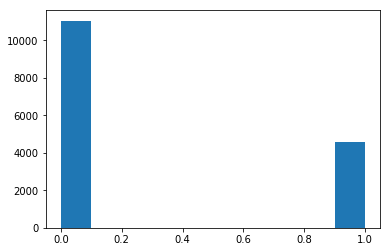

In [73]:
logist = LogisticRegression()
logist.fit(X_train,y_train)
logpred = logist.predict(X_test)
plt.hist(logpred)

In [74]:
log_pred_outcome = [0 if x < .61 else 1 for x in logpred]

In [75]:
accuracy_score(y_test, log_pred_outcome)

0.7514694607717863

In [76]:
confusion_matrix(y_test, log_pred_outcome, labels=[0,1])

array([[8346, 1188],
       [2702, 3416]])

In [77]:
print(classification_report(y_test, log_pred_outcome, target_names=['adopted', 'not adopted']))

             precision    recall  f1-score   support

    adopted       0.76      0.88      0.81      9534
not adopted       0.74      0.56      0.64      6118

avg / total       0.75      0.75      0.74     15652



In [78]:
roc_auc_score(y_test, log_pred_outcome)

0.716872865941909

## Gausian NB

(array([11658.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3994.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

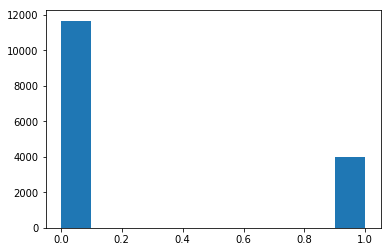

In [79]:
model_naive = GaussianNB()
model_naive.fit(X_train, y_train)
nbpred = model_naive.predict(X_test)
plt.hist(nbpred)

In [80]:
nb_pred_outcome = [0 if x < .61 else 1 for x in nbpred]

In [81]:
accuracy_score(y_test, nb_pred_outcome)

0.7946588295425505

In [82]:
confusion_matrix(y_test, nb_pred_outcome, labels=[0,1])

array([[8989,  545],
       [2669, 3449]])

In [83]:
print(classification_report(y_test, nb_pred_outcome, target_names=['adopted', 'not adopted']))

             precision    recall  f1-score   support

    adopted       0.77      0.94      0.85      9534
not adopted       0.86      0.56      0.68      6118

avg / total       0.81      0.79      0.78     15652



In [84]:
roc_auc_score(y_test, nb_pred_outcome)

0.7532912438153418

## SVM 

This was very slow and didn't have good results, so it is commented out for ease of running the notebook. 

In [85]:
#reminder, this cell is VERY slow
#supp = SVC()
#supp.fit(X_train,y_train)

In [86]:
#svm_pred = supp.predict(X_test)
#print(ypred)

In [87]:
#accuracy_score(y_test, ypred)

In [88]:
#confusion_matrix(y_test, ypred)

In [89]:
#print(classification_report(y_test, ypred, target_names=['adopted', 'not adopted']))

In [90]:
#roc_auc_score(y_test, ypred)

## Decision Tree 

(array([9338.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6314.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

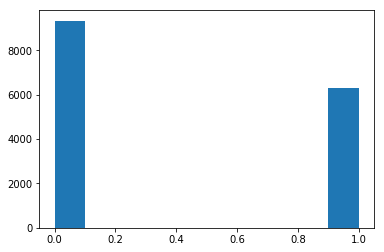

In [91]:
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
dtpred = model_tree.predict(X_test)
plt.hist(dtpred)

In [92]:
dt_pred_outcome = [0 if x< .5 else 1 for x in dtpred]

In [93]:
accuracy_score(y_test,dt_pred_outcome)

0.7846920521339126

In [94]:
confusion_matrix(y_test, dt_pred_outcome)

array([[7751, 1783],
       [1587, 4531]])

In [95]:
print(classification_report(y_test, dt_pred_outcome, target_names=['adopted', 'not adopted']))

             precision    recall  f1-score   support

    adopted       0.83      0.81      0.82      9534
not adopted       0.72      0.74      0.73      6118

avg / total       0.79      0.78      0.79     15652



In [96]:
roc_auc_score(y_test, dt_pred_outcome)

0.7767933048480231

With LabelEncoding, Decisions Trees had the best accuracy score and area under the roc curve. KMeans had the worst metrics.  

## One-Hot Encoding and LabelEncoding

In [97]:
data.columns

Index(['animal_type', 'breed', 'color', 'sex_upon_outcome',
       'age_upon_outcome_num', 'date_of_birth_dt', 'outcome_dt', 'has_name',
       'outcome'],
      dtype='object')

In [98]:
data_one_hot = data.copy()
data_one_hot['outcome'] = labelencoder.fit_transform(data_one_hot['outcome'])
data_one_hot['date_of_birth_dt'] = labelencoder.fit_transform(data_one_hot['date_of_birth_dt'])
data_one_hot['outcome_dt'] = labelencoder.fit_transform(data_one_hot['outcome_dt'])
cols_to_transform = ['animal_type', 'breed', 'color', 'sex_upon_outcome']
df_with_dummies = pd.get_dummies( columns = cols_to_transform, data=data_one_hot )
df_with_dummies.head(5)

,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,...,color_Yellow/Orange,color_Yellow/Orange Tabby,color_Yellow/Tan,color_Yellow/White,color_Yellow/Yellow,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
0,0.038462,4624,12401,False,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1.000000,4016,1642,True,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.000000,4161,9927,True,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,9.000000,1401,10447,True,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.416667,4443,11509,False,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [99]:
y_indices = [0,1,2,3] + list(range(5,2668))
len(y_indices)

2667

In [100]:
x = df_with_dummies.iloc[:,y_indices] #all rows, all the features and no outcome
y = df_with_dummies.iloc[:,4] #all rows, outcome only
# scaler = StandardScaler()
# x=scaler.fit_transform(x)
# pca = PCA(n_components=6)
# x = pca.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=4)

In [101]:
y.head()

0    1
1    1
2    0
3    1
4    1
Name: outcome, dtype: int64

## Linear Regression

In [102]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print(lr.intercept_)
print(lr.coef_)

1.2041993807651152
[-2.98731042e-02 -1.21817619e-04  7.87146954e-07 ... -2.82835199e-01
 -2.94758150e-01  2.43231465e-01]


[0.18320158 0.0934981  0.18192669 ... 0.1456806  0.16223214 0.93415333]


(array([9.000e+00, 6.100e+01, 3.470e+03, 6.061e+03, 2.257e+03, 1.579e+03,
        2.190e+03, 1.800e+01, 4.000e+00, 3.000e+00]),
 array([-0.63699623, -0.38134677, -0.12569732,  0.12995214,  0.3856016 ,
         0.64125106,  0.89690051,  1.15254997,  1.40819943,  1.66384888,
         1.91949834]),
 <a list of 10 Patch objects>)

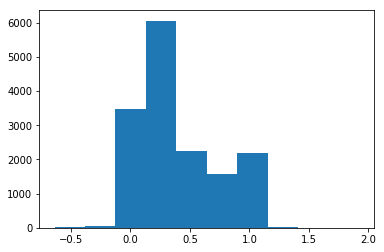

In [103]:
lrpred = lr.predict(X_test)
print(lrpred)
plt.hist(lrpred)

In [104]:
lr_pred_outcome = [0 if x < .5 else 1 for x in lrpred]

In [105]:
lr_accuracy = accuracy_score(y_test, lr_pred_outcome)
lr_accuracy

0.815742397137746

In [106]:
lr_conf_matrix = confusion_matrix(y_test, lr_pred_outcome, labels=[0,1])
lr_conf_matrix

array([[8674,  860],
       [2024, 4094]])

In [107]:
lr_roc = roc_auc_score(y_test, lr_pred_outcome)
lr_roc

0.7894847250284301

## Logistic Regression

(array([11309.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4343.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

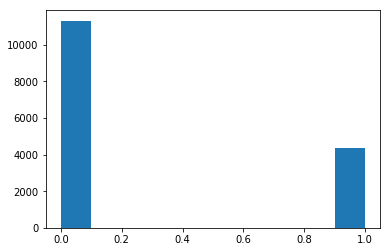

In [108]:
logit = LogisticRegression()
logit.fit(X_train,y_train)
logpred = logit.predict(X_test)
plt.hist(logpred)

In [109]:
log_pred_outcome = [0 if x < .5 else 1 for x in logpred]
log_accuracy = accuracy_score(y_test, log_pred_outcome)
log_accuracy 

0.8094173268591873

In [110]:
log_conf_matrix = confusion_matrix(y_test, log_pred_outcome, labels=[0,1])
log_conf_matrix

array([[8930,  604],
       [2379, 3739]])

In [111]:
log_roc = roc_auc_score(y_test, log_pred_outcome)
log_roc

0.7738976103349736

## GausianNB 

(array([11420.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4232.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

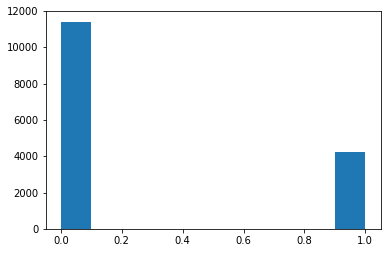

In [112]:
model_naive = GaussianNB()
model_naive.fit(X_train, y_train)
nbpred = model_naive.predict(X_test)
plt.hist(nbpred)

In [113]:
nb_pred_outcome = [0 if x < .5 else 1 for x in nbpred]
gnb_accuracy = accuracy_score(y_test, nb_pred_outcome)
gnb_accuracy 

0.8016866854076157

In [114]:
nb_conf_matrix = confusion_matrix(y_test, nb_pred_outcome, labels=[0,1])
nb_conf_matrix

array([[8925,  609],
       [2495, 3623]])

In [115]:
gnb_roc = roc_auc_score(y_test, nb_pred_outcome)
gnb_roc

0.7641551686148911

## Decision Tree

(array([9680.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5972.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

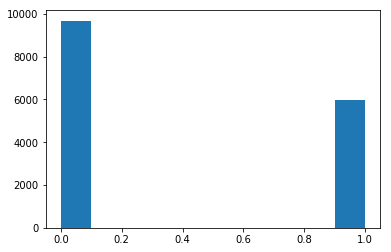

In [116]:
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
dtpred = model_tree.predict(X_test)
plt.hist(dtpred)

In [117]:
dt_pred_outcome = [0 if x < .5 else 1 for x in dtpred]
tree_accuracy = accuracy_score(y_test, dt_pred_outcome)
tree_accuracy

0.7982366470738563

In [118]:
dt_conf_matrix = confusion_matrix(y_test, dt_pred_outcome, labels=[0,1])
dt_conf_matrix

array([[8028, 1506],
       [1652, 4466]])

In [119]:
tree_roc = roc_auc_score(y_test, dt_pred_outcome)
tree_roc 

0.7860080674776387

## Comparisons and Conclusion

<BarContainer object of 4 artists>

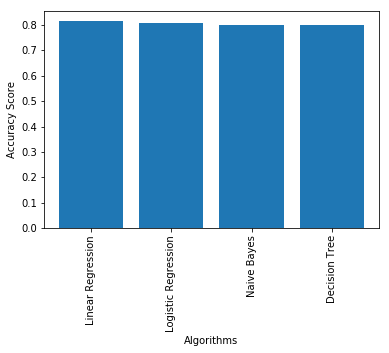

In [120]:
labels = ['Linear Regression', 'Logistic Regression', 'Naive Bayes', 'Decision Tree']
plt.xticks(rotation='vertical')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy Score')
plt.bar(labels,[lr_accuracy,log_accuracy,gnb_accuracy,tree_accuracy])

<BarContainer object of 4 artists>

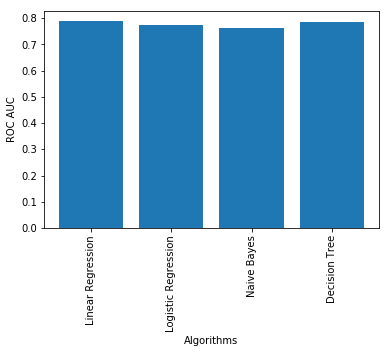

In [121]:
labels = ['Linear Regression', 'Logistic Regression', 'Naive Bayes', 'Decision Tree']
plt.xticks(rotation='vertical')
plt.xlabel('Algorithms')
plt.ylabel('ROC AUC')
plt.bar(labels,[lr_roc,log_roc,gnb_roc,tree_roc])

In [122]:
print("Linear Regression Confusion Matrix\n", lr_conf_matrix)

Linear Regression Confusion Matrix
 [[8674  860]
 [2024 4094]]


In [123]:
print("Logistic Regression Confusion Matrix\n", log_conf_matrix)

Logistic Regression Confusion Matrix
 [[8930  604]
 [2379 3739]]


In [124]:
print("Naive Bayes Confusion Matrix\n", nb_conf_matrix)

Naive Bayes Confusion Matrix
 [[8925  609]
 [2495 3623]]


In [125]:
print("Decision Tree Confusion Matrix\n", dt_conf_matrix)

Decision Tree Confusion Matrix
 [[8028 1506]
 [1652 4466]]


With One Hot Encoding mixed with Label Encoding, all of the models performed better than they did with label encoding alone. All three performed pretty combarabily in both accuracy score and in area under the roc curve. Surpirisingly, linear regression ended up having higher metrics than both Naive Bayes and Decision Tree. 

# Post Midterm Additional Exploring

## Incorrectly Classified rows 

In [126]:
data.head()

,animal_type,breed,color,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome
0,Cat,Domestic Shorthair Mix,Orange Tabby,Intact Male,0.038462,2014-07-07,2014-07-22 16:04:00,False,not
1,Dog,Beagle Mix,White/Brown,Spayed Female,1.000000,2012-11-06,2013-11-07 11:47:00,True,not
2,Dog,Pit Bull,Blue/White,Neutered Male,1.000000,2013-03-31,2014-06-03 14:20:00,True,adopted
3,Dog,Miniature Schnauzer Mix,White,Neutered Male,9.000000,2005-06-02,2014-06-15 15:50:00,True,not
4,Other,Bat Mix,Brown,Unknown,0.416667,2014-01-07,2014-07-07 14:04:00,False,not


In [127]:
final_data = data
final_data['outcome_bin'] = y
final_data.head()

,animal_type,breed,color,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome,outcome_bin
0,Cat,Domestic Shorthair Mix,Orange Tabby,Intact Male,0.038462,2014-07-07,2014-07-22 16:04:00,False,not,1
1,Dog,Beagle Mix,White/Brown,Spayed Female,1.000000,2012-11-06,2013-11-07 11:47:00,True,not,1
2,Dog,Pit Bull,Blue/White,Neutered Male,1.000000,2013-03-31,2014-06-03 14:20:00,True,adopted,0
3,Dog,Miniature Schnauzer Mix,White,Neutered Male,9.000000,2005-06-02,2014-06-15 15:50:00,True,not,1
4,Other,Bat Mix,Brown,Unknown,0.416667,2014-01-07,2014-07-07 14:04:00,False,not,1


In [128]:
final_data = X_test.copy()
final_data['outcome'] = y_test
final_data['predoutcome_lr'] = lr_pred_outcome
final_data.head()

,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,breed_Abyssinian Mix,...,color_Yellow/Tan,color_Yellow/White,color_Yellow/Yellow,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,outcome,predoutcome_lr
4825,2.000000,3692,9206,True,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
44862,1.000000,5063,44846,True,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
75617,0.166667,5086,34592,True,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
39747,0.166667,5041,32499,False,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
70759,1.000000,4573,26528,True,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [129]:
wrong_data = final_data[final_data.outcome != final_data.predoutcome_lr]
right_data = final_data[final_data.outcome == final_data.predoutcome_lr]
wrong_data.head()

,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,breed_Abyssinian Mix,...,color_Yellow/Tan,color_Yellow/White,color_Yellow/Yellow,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,outcome,predoutcome_lr
54622,2.0,4894,52364,False,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
12339,8.0,1555,2725,True,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
20086,4.0,2961,6407,True,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
37417,3.0,4107,35956,True,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
10134,4.0,3149,11171,True,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [130]:
print(len(wrong_data), " classified incorrectly")
print(len(right_data), " classified correctly")
print(len(final_data), "total")

2884  classified incorrectly
12768  classified correctly
15652 total


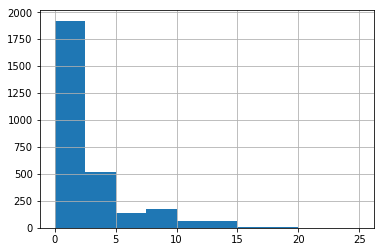

In [131]:
wrong_data['age_upon_outcome_num'].hist()

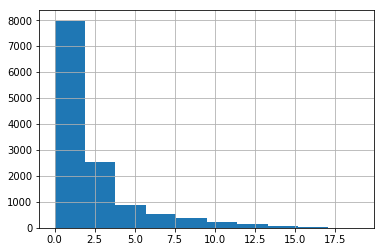

In [132]:
right_data['age_upon_outcome_num'].hist()

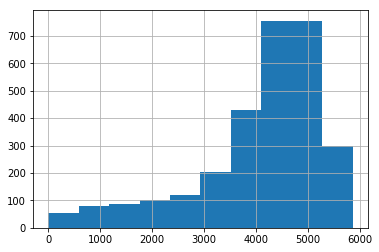

In [133]:
wrong_data['date_of_birth_dt'].hist()

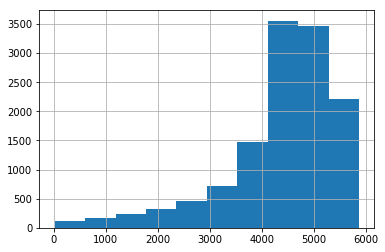

In [134]:
right_data['date_of_birth_dt'].hist()

AxesSubplot(0.125,0.125;0.775x0.755)


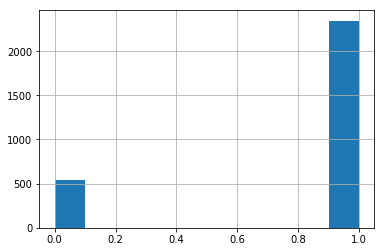

In [135]:
print(wrong_data['has_name'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


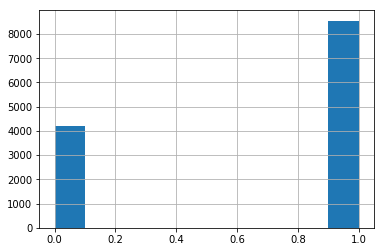

In [136]:
print(right_data['has_name'].hist())

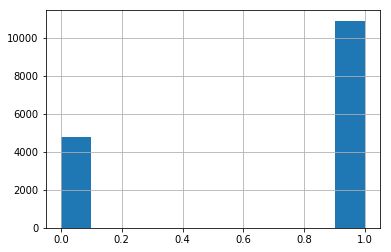

In [137]:
X_test['has_name'].hist()

There's a lower proportion of animals without names that are incorrectly classified. So it is correctly classifying animals without names more often than those with names

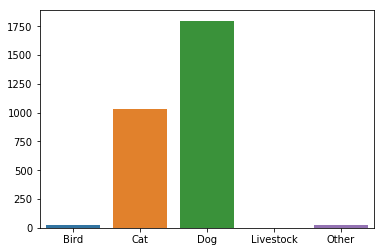

In [138]:
y=[len(wrong_data[wrong_data['animal_type_Bird'] == 1]),
   len(wrong_data[wrong_data['animal_type_Cat'] == 1]),
   len(wrong_data[wrong_data['animal_type_Dog'] == 1]),
   len(wrong_data[wrong_data['animal_type_Livestock'] == 1]),
   len(wrong_data[wrong_data['animal_type_Other'] == 1])]
   
#y
sns.barplot(x=['Bird', 'Cat', 'Dog','Livestock', 'Other'], y=y)

This looks pretty comparable to the original data

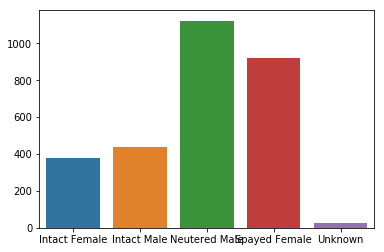

In [139]:
y=[len(wrong_data[wrong_data['sex_upon_outcome_Intact Female'] == 1]),
   len(wrong_data[wrong_data['sex_upon_outcome_Intact Male'] == 1]),
   len(wrong_data[wrong_data['sex_upon_outcome_Neutered Male'] == 1]),
   len(wrong_data[wrong_data['sex_upon_outcome_Spayed Female'] == 1]),
   len(wrong_data[wrong_data['sex_upon_outcome_Unknown'] == 1])]
x=['Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female', 'Unknown']
sns.barplot(x=x,y=y)

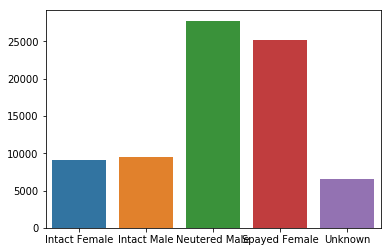

In [140]:
sns.barplot(x=['Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female', 'Unknown'], y=data.groupby('sex_upon_outcome').size())

Once again, fairly comparable. Fewer unknown in the wrong data set. 

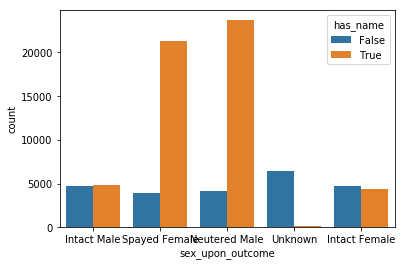

In [141]:
p = sns.countplot(data=data,
                  x = 'sex_upon_outcome',
                  hue = 'has_name')

In [142]:
data.head() 

,animal_type,breed,color,sex_upon_outcome,age_upon_outcome_num,date_of_birth_dt,outcome_dt,has_name,outcome,outcome_bin
0,Cat,Domestic Shorthair Mix,Orange Tabby,Intact Male,0.038462,2014-07-07,2014-07-22 16:04:00,False,not,1
1,Dog,Beagle Mix,White/Brown,Spayed Female,1.000000,2012-11-06,2013-11-07 11:47:00,True,not,1
2,Dog,Pit Bull,Blue/White,Neutered Male,1.000000,2013-03-31,2014-06-03 14:20:00,True,adopted,0
3,Dog,Miniature Schnauzer Mix,White,Neutered Male,9.000000,2005-06-02,2014-06-15 15:50:00,True,not,1
4,Other,Bat Mix,Brown,Unknown,0.416667,2014-01-07,2014-07-07 14:04:00,False,not,1


## Grid Search CV

In [143]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=20)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": 6,
              "min_samples_split": 3,
              "min_samples_leaf": 3,
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

#random_search.fit(X_train, y_train)

In [145]:
param_grid = {"max_depth": [3, 10],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True, False], 'min_samples_leaf': [1, 3, 10], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

(array([15181.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   471.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

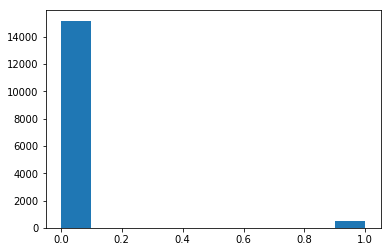

In [148]:
grid_pred = grid_search.predict(X_test)
plt.hist(grid_pred)

In [150]:
accuracy_score(grid_pred,y_test)

0.6392154357270636

This took a VERY long time to run. 63% accuracy score was not great

In [174]:
x = data_label_encoded.iloc[:,:8] #all rows, all the features and no outcome
y = data_label_encoded.iloc[:,8] #all rows, outcome only
# scaler = StandardScaler()
# x=scaler.fit_transform(x)
# pca = PCA(n_components=6)
# x = pca.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=4)

In [175]:
lr = LinearRegression()
param_grid = {"max_depth": [3, 10],
              "max_features": [1, 3, 8],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)

In [176]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True, False], 'min_samples_leaf': [1, 3, 10], 'max_features': [1, 3, 8], 'min_samples_split': [2, 3, 10], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

(array([11232.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4420.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

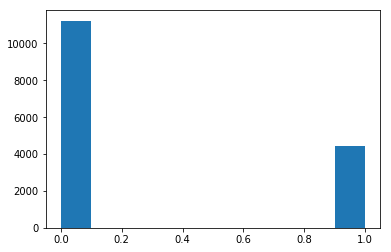

In [177]:
grid_pred = grid_search.predict(X_test)
plt.hist(grid_pred)

In [178]:
accuracy_score(grid_pred,y_test)

0.8435982622029133

In [183]:
grid_search_roc = roc_auc_score(grid_pred,y_test)
grid_search_roc

0.865298202614379

GridSearchCV had a higher accuracy score with the Label Encoded data than one hot encoding. However, this makes sense because the max columns was 20, so out of the over 2,000 columns, it wouldn't be a very good representation of all the data present. 

In [179]:


class EnsembleLearning():
    def __init__(self, model_1, model_2, model_3):
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3
    
    def fit(self, X, y):
        self.model_1.fit(X,y)
        self.model_2.fit(X,y)
        self.model_3.fit(X,y)
        
    def predict(self, y):
        pred_1 = self.model_1.predict(y)
        pred_2 = self.model_2.predict(y)
        pred_3 = self.model_3.predict(y)
        
        final_pred = []
        for i in range(len(pred_1)):
        
            if (pred_1[i] + pred_2[i] + pred_3[i]) >= 2:
                final_pred.append(1)
            else:
                final_pred.append(0)
            
        return final_pred
        

In [180]:
x = df_with_dummies.iloc[:,y_indices] #all rows, all the features and no outcome
y = df_with_dummies.iloc[:,4] #all rows, outcome only
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=4)

In [181]:
ensemble = EnsembleLearning(LinearRegression(), LogisticRegression(), DecisionTreeClassifier())
ensemble.fit(X_train, y_train)

In [170]:
ensemble_pred = ensemble.predict(X_test)

In [171]:
accuracy_score(ensemble_pred, y_test)

0.8267314081267569

In [185]:
ensemble_roc = roc_auc_score(ensemble_pred, y_test)

The ensemble prediction had about a 2% higher accuracy than each model alone. It had a much higher ROC AUC score as well.  

<BarContainer object of 5 artists>

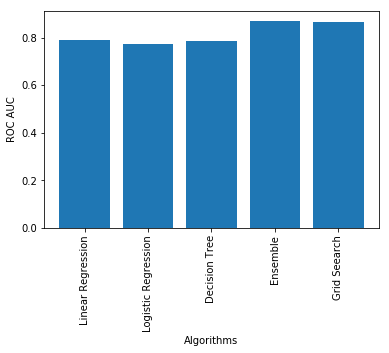

In [186]:
labels = ['Linear Regression', 'Logistic Regression', 'Decision Tree', 'Ensemble', 'Grid Seearch']
plt.xticks(rotation='vertical')
plt.xlabel('Algorithms')
plt.ylabel('ROC AUC')
plt.bar(labels,[lr_roc,log_roc,tree_roc, ensemble_roc,grid_search_roc])